In [29]:
!pip install kaggle -q

In [30]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [31]:
kaggle_config = json.load(open("kaggle.json"))

In [32]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [33]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [34]:
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [36]:
df = pd.read_csv("spotify_millsongdata.csv")

In [37]:
df.shape

(57650, 4)

In [38]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [40]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [41]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Alabama             187
Reba Mcentire       187
Cher                187
Loretta Lynn        187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [42]:
# Taking a small sample and arranging it properly
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)

In [43]:
df.shape

(10000, 3)

In [44]:
df.head()

,artist,song,text
0,Manowar,Courage,Some Want To Think Hope Is Lost See Me Stand A...
1,Enigma,Return To Innocence,Love \r\nDevotion \r\nFeeling \r\nEmotion ...
2,Halloween,Ghostbusters,Ghostbusters \r\nIf there's something strange...
3,Uriah Heep,Circus,Walkin' around this concrete garden \r\nViewi...
4,Linkin Park,Rolling In The Deep,There's a fire starting in my heart \r\nReach...


In [45]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

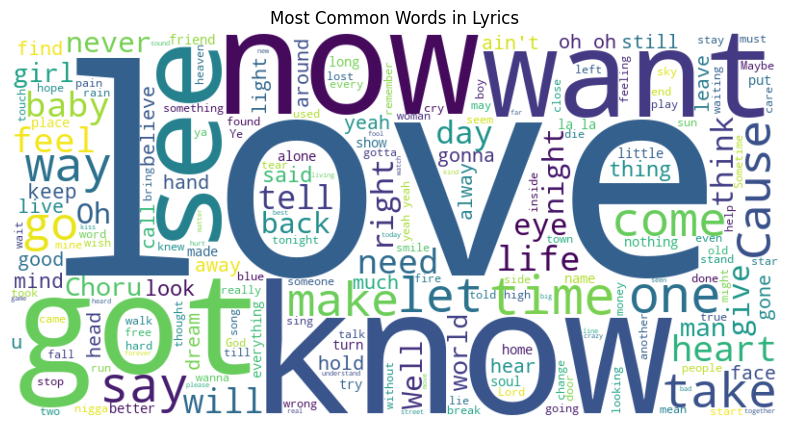

In [46]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

DATA PREPROCESSING

In [51]:
# download nltk data (Natural Language Toolkit)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords') # Ex: is, the, and.... (Useless words in the text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
stop_words = set(stopwords.words('english'))

In [58]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text) # ["Love", "Heart", "the", "is"]
    tokens = [word for word in tokens if word not in stop_words] # ["Love", "Heart"]
    return " ".join(tokens) # "love heart"

In [59]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [60]:
df.head()

,artist,song,text,cleaned_text
0,Manowar,Courage,Some Want To Think Hope Is Lost See Me Stand A...,want think hope lost see stand alone cant othe...
1,Enigma,Return To Innocence,Love \r\nDevotion \r\nFeeling \r\nEmotion ...,love devotion feeling emotion dont afraid weak...
2,Halloween,Ghostbusters,Ghostbusters \r\nIf there's something strange...,ghostbusters theres something strange neighbor...
3,Uriah Heep,Circus,Walkin' around this concrete garden \r\nViewi...,walkin around concrete garden viewing vain thi...
4,Linkin Park,Rolling In The Deep,There's a fire starting in my heart \r\nReach...,theres fire starting heart reaching fever pitc...


In [61]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [62]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [66]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim= cosine_sim, df= df, top_n= 5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [67]:
df["song"][2]

'Ghostbusters'

In [75]:
# Example Recommendation
sng = input("song input: ")
print(f"\nRecommendations for the song : {sng}")
recommendations = recommend_songs(sng) # df["song"][2]
print(recommendations)


Recommendations for the song : Courage
              artist                 song
1015         Erasure  My Heart... So Blue
1745         Alabama              Goodbye
7554      Don McLean       You Have Lived
3063  Elvis Costello        High Fidelity
3818    Van Morrison         Cry For Home
